In [1]:
cd ..

/home/vmadmin/pass


In [2]:
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, make_scorer, confusion_matrix
from sklearn.naive_bayes import BernoulliNB
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC

from database.utils import get_train_test_data
from pipelines.feature_extractor import get_feature_extractor
from pipelines.models import get_ensemble_model
from feature_extraction.features import get_glove_w2v
from evaluation.metrics import class_report

from copy import deepcopy
import numpy as np
import pandas as pd
import pprint
import time

%load_ext autoreload
%autoreload 2

In [3]:
w2v = get_glove_w2v()
train_test_data = get_train_test_data()
feature_extractor = get_feature_extractor(w2v)

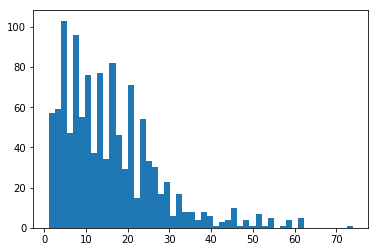

In [17]:
from feature_extraction.transformers import *
import matplotlib.pyplot as plt

%matplotlib inline

avg = NumWordExtractor()

values = avg.fit_transform(train_test_data[0][0], train_test_data[0][1])

plt.hist(values, bins=50);

In [136]:
feature_extractor = get_feature_extractor(w2v)

In [26]:
ensemble = get_ensemble_model(w2v)

In [137]:
ensemble = get_ensemble_model(w2v)
ensemble.steps = ensemble.steps[2:]

In [138]:
%%time

models = [("lr", LogisticRegression(C=0.1, penalty='l2', solver='lbfgs', n_jobs=-1)),
           ("nb", BernoulliNB(alpha=5.0)),
           ("rf", RandomForestClassifier(n_estimators=300, max_depth=10, min_samples_split=5, n_jobs=-1)),
           ("xgb", XGBClassifier(n_estimators=300, max_depth=8, n_jobs=-1)),
           ("et", ExtraTreesClassifier(n_estimators=300, max_depth=10, min_samples_split=10, n_jobs=-1)),
           #("svm", SVC(C=100, gamma=0.0001, probability=True)),
           ("ensemble", ensemble),
           #("nbsvm", )
         ]

results = {}

for Xr_train, y_train, Xr_test, y_test, indicator in train_test_data:
    X_train = feature_extractor.fit_transform(Xr_train, y_train)
    X_test = feature_extractor.transform(Xr_test)
    print(indicator, X_train.shape)
    
    results[indicator] = {}
    for name, classifier in models:
        results[indicator][name] = {}
        
        cv = StratifiedKFold(n_splits=5, random_state=42)
        scores = []
        conf_mat = np.zeros((2, 2))      # Binary classification
        false_pos = set()
        false_neg = set()
        train_times = []
        predict_times = []
        
        for dev_i, val_i in cv.split(X_train, y_train):
            clf = deepcopy(classifier)
            X_dev, X_val = X_train[dev_i], X_train[val_i]
            y_dev, y_val = y_train[dev_i], y_train[val_i]
            ts = time.time()

            clf.fit(X_dev, y_dev)
            te = time.time()
            
            train_times.append(te - ts)
            
            ts = time.time()
            y_pprobs = clf.predict_proba(X_val)       # Predicted probabilities
            te = time.time()
            
            predict_times.append(te - ts)
            
            y_plabs = np.squeeze(clf.predict(X_val))  # Predicted class labels

            scores.append(roc_auc_score(y_val, y_pprobs[:, 1]))
            confusion = confusion_matrix(y_val, y_plabs)
            conf_mat += confusion

            # Collect indices of false positive and negatives
            fp_i = np.where((y_plabs==1) & (y_val==0))[0]
            fn_i = np.where((y_plabs==0) & (y_val==1))[0]
            false_pos.update(val_i[fp_i])
            false_neg.update(val_i[fn_i])

        classifier.fit(X_train, y_train)
        y_scores_test = classifier.predict_proba(X_test)
        results[indicator][name]['test_roc_auc'] = roc_auc_score(y_test, y_scores_test[:, 1])        
            
        print("\n[%s][%s] Mean score: %0.2f (+/- %0.2f)" % (indicator, name, np.mean(scores), np.std(scores) * 2))
        #conf_mat /= 5
        #print("Mean CM: \n", conf_mat)
        #print("\nMean classification measures: \n")
        measures = class_report(conf_mat)
        for metric in measures:
            results[indicator][name][metric] = measures[metric]
        
        results[indicator][name]['mean_roc_auc'] = np.mean(scores)
        results[indicator][name]['std_roc_auc'] = np.std(scores) * 2
        results[indicator][name]['train_time'] = np.mean(train_times)
        results[indicator][name]['predict_time'] = np.mean(predict_times)
        
        #pprint.pprint(measures)

sleep (1146, 1150)

[sleep][lr] Mean score: 0.73 (+/- 0.12)

[sleep][nb] Mean score: 0.88 (+/- 0.14)

[sleep][rf] Mean score: 0.88 (+/- 0.13)

[sleep][xgb] Mean score: 0.88 (+/- 0.13)

[sleep][et] Mean score: 0.88 (+/- 0.13)

[sleep][ensemble] Mean score: 0.90 (+/- 0.12)
sedentary_behaviour (4294, 3030)

[sedentary_behaviour][lr] Mean score: 0.72 (+/- 0.07)

[sedentary_behaviour][nb] Mean score: 0.80 (+/- 0.13)

[sedentary_behaviour][rf] Mean score: 0.78 (+/- 0.16)

[sedentary_behaviour][xgb] Mean score: 0.83 (+/- 0.11)

[sedentary_behaviour][et] Mean score: 0.77 (+/- 0.14)

[sedentary_behaviour][ensemble] Mean score: 0.83 (+/- 0.12)
physical_activity (2630, 4321)

[physical_activity][lr] Mean score: 0.80 (+/- 0.24)

[physical_activity][nb] Mean score: 0.85 (+/- 0.27)

[physical_activity][rf] Mean score: 0.87 (+/- 0.26)

[physical_activity][xgb] Mean score: 0.89 (+/- 0.19)

[physical_activity][et] Mean score: 0.86 (+/- 0.27)

[physical_activity][ensemble] Mean score: 0.89 (+/- 0.21)
CP

In [139]:
pd.DataFrame(results['physical_activity']).T

,accuracy,f1score,mean_roc_auc,precision,predict_time,sensitivity,specificity,std_roc_auc,test_roc_auc,train_time
ensemble,0.796198,0.799551,0.889585,0.779723,0.878228,0.820414,0.772419,0.210309,0.882631,14.956167
et,0.765399,0.783736,0.859072,0.815463,0.410299,0.754386,0.779617,0.265815,0.821245,2.528066
lr,0.731939,0.738792,0.803162,0.727206,0.000786,0.750753,0.712750,0.242002,0.820383,1.379566
nb,0.770342,0.770167,0.846823,0.738147,0.004413,0.805091,0.738529,0.270579,0.792431,0.012021
rf,0.771863,0.780220,0.866574,0.776805,0.410395,0.783664,0.759245,0.259684,0.850539,2.826343
xgb,0.799240,0.799392,0.893670,0.767323,0.050960,0.834259,0.766983,0.187175,0.887941,6.889996


In [142]:
pd.DataFrame(results['sedentary_behaviour']).T

,accuracy,f1score,mean_roc_auc,precision,predict_time,sensitivity,specificity,std_roc_auc,test_roc_auc,train_time
ensemble,0.779460,0.837759,0.826606,0.886191,0.892192,0.794347,0.741776,0.117269,0.817211,17.434522
et,0.731020,0.819447,0.774373,0.949982,0.412209,0.720451,0.789634,0.142388,0.766929,2.525241
lr,0.696320,0.784534,0.718899,0.860457,0.000936,0.720923,0.615385,0.074059,0.712065,1.221552
nb,0.768514,0.820448,0.801164,0.823124,0.005250,0.817789,0.678312,0.131102,0.742334,0.014822
rf,0.753610,0.821163,0.782461,0.880391,0.412284,0.769401,0.709763,0.155781,0.777350,2.944961
xgb,0.776898,0.835959,0.826860,0.884741,0.058966,0.792275,0.737840,0.114628,0.813119,8.450702


In [143]:
pd.DataFrame(results['sleep']).T

,accuracy,f1score,mean_roc_auc,precision,predict_time,sensitivity,specificity,std_roc_auc,test_roc_auc,train_time
ensemble,0.834206,0.875164,0.899883,0.906122,0.438396,0.846252,0.807799,0.116856,0.793040,8.281743
et,0.803665,0.862048,0.881375,0.956463,0.211263,0.784598,0.872000,0.128431,0.784249,2.311947
lr,0.689354,0.774112,0.729297,0.829932,0.000640,0.725327,0.590164,0.120554,0.622344,0.925661
nb,0.800175,0.843258,0.884915,0.838095,0.001642,0.848485,0.716667,0.139500,0.739414,0.004538
rf,0.808901,0.859345,0.882554,0.910204,0.214055,0.813869,0.796296,0.129001,0.768278,2.553634
xgb,0.810646,0.854460,0.881951,0.866667,0.012635,0.842593,0.748718,0.132556,0.773626,1.385054


In [20]:
%%time

models = [("lr", LogisticRegression(C=0.1, penalty='l2', solver='lbfgs', n_jobs=-1)),
           ("nb", BernoulliNB(alpha=5.0)),
           ("rf", RandomForestClassifier(n_estimators=300, max_depth=10, min_samples_split=5, n_jobs=-1)),
           ("xgb", XGBClassifier(n_estimators=300, max_depth=8, n_jobs=-1)),
           ("et", ExtraTreesClassifier(n_estimators=300, max_depth=10, min_samples_split=10, n_jobs=-1)),
           ("svm", SVC(C=100, gamma=0.0001, probability=True)),
           ("ensemble", ensemble),
           #("nbsvm", )
         ]

results = {}

for X_raw, y, indicator in data:
    X = feature_extractor.fit_transform(X_raw, y)
    results[indicator] = {}
    for name, classifier in models:
        results[indicator][name] = {}
        
        cv = StratifiedKFold(n_splits=5, random_state=42)
        scores = []
        conf_mat = np.zeros((2, 2))      # Binary classification
        false_pos = set()
        false_neg = set()
        train_times = []
        
        for train_i, val_i in cv.split(X, y):
            clf = deepcopy(classifier)
            X_train, X_val = X[train_i], X[val_i]
            y_train, y_val = y[train_i], y[val_i]
            ts = time.time()

            clf.fit(X_train, y_train)
            te = time.time()
            
            train_times.append(te - ts)
            
            y_pprobs = clf.predict_proba(X_val)       # Predicted probabilities
            y_plabs = np.squeeze(clf.predict(X_val))  # Predicted class labels

            scores.append(roc_auc_score(y_val, y_pprobs[:, 1]))
            confusion = confusion_matrix(y_val, y_plabs)
            conf_mat += confusion

            # Collect indices of false positive and negatives
            fp_i = np.where((y_plabs==1) & (y_val==0))[0]
            fn_i = np.where((y_plabs==0) & (y_val==1))[0]
            false_pos.update(val_i[fp_i])
            false_neg.update(val_i[fn_i])

        print("\n[%s][%s] Mean score: %0.2f (+/- %0.2f)" % (indicator, name, np.mean(scores), np.std(scores) * 2))
        #conf_mat /= 5
        #print("Mean CM: \n", conf_mat)
        #print("\nMean classification measures: \n")
        measures = class_report(conf_mat)
        for metric in measures:
            results[indicator][name][metric] = measures[metric]
        
        results[indicator][name]['mean_roc_auc'] = np.mean(scores)
        results[indicator][name]['std_roc_auc'] = np.std(scores) * 2
        results[indicator][name]['train_time'] = np.mean(train_times)
        #pprint.pprint(measures)


[sleep][lr] Mean score: 0.87 (+/- 0.04)

[sleep][nb] Mean score: 0.95 (+/- 0.02)

[sleep][rf] Mean score: 0.90 (+/- 0.06)

[sleep][xgb] Mean score: 0.86 (+/- 0.03)

[sleep][et] Mean score: 0.90 (+/- 0.04)

[sleep][svm] Mean score: 0.86 (+/- 0.04)

[sleep][ensemble] Mean score: 0.92 (+/- 0.05)

[sedentary_behaviour][lr] Mean score: 0.87 (+/- 0.15)

[sedentary_behaviour][nb] Mean score: 0.93 (+/- 0.16)

[sedentary_behaviour][rf] Mean score: 0.85 (+/- 0.26)

[sedentary_behaviour][xgb] Mean score: 0.90 (+/- 0.16)

[sedentary_behaviour][et] Mean score: 0.86 (+/- 0.23)

[sedentary_behaviour][svm] Mean score: 0.86 (+/- 0.16)

[sedentary_behaviour][ensemble] Mean score: 0.90 (+/- 0.19)

[physical_activity][lr] Mean score: 0.88 (+/- 0.06)

[physical_activity][nb] Mean score: 0.97 (+/- 0.03)

[physical_activity][rf] Mean score: 0.88 (+/- 0.10)

[physical_activity][xgb] Mean score: 0.86 (+/- 0.07)

[physical_activity][et] Mean score: 0.84 (+/- 0.11)

[physical_activity][svm] Mean score: 0.86 (+/

In [21]:
pd.DataFrame(results['physical_activity']).T

,accuracy,f1score,mean_roc_auc,precision,sensitivity,specificity,std_roc_auc,train_time
ensemble,0.951934,0.975319,0.902961,1.000000,0.951827,1.000000,0.067394,9.435405
et,0.948066,0.973341,0.839654,0.998255,0.949640,0.000000,0.110316,2.243759
lr,0.953591,0.976000,0.879777,0.993601,0.959012,0.620690,0.063690,0.793034
nb,0.957459,0.977969,0.970510,0.994183,0.962275,0.705882,0.033964,0.008714
rf,0.949171,0.973878,0.881364,0.997673,0.951192,0.428571,0.095110,2.445561
svm,0.951934,0.975319,0.855466,1.000000,0.951827,1.000000,0.061755,0.966141
xgb,0.949724,0.974126,0.856645,0.996510,0.952725,0.500000,0.073139,3.182969


In [43]:
pd.DataFrame(results['sedentary_behaviour']).T

,accuracy,f1score,mean_roc_auc,precision,sensitivity,specificity,std_roc_auc,train_time
ensemble,0.937127,0.966639,0.904497,0.996084,0.938884,0.880000,0.187142,12.326693
et,0.934739,0.965517,0.860333,0.999130,0.934093,0.963636,0.234821,2.352192
lr,0.932750,0.964081,0.872131,0.986945,0.942252,0.716981,0.153806,0.926467
nb,0.958615,0.977547,0.927240,0.985205,0.970009,0.810056,0.157551,0.016102
rf,0.935137,0.965691,0.854135,0.998259,0.935181,0.933333,0.255848,2.608832
svm,0.929964,0.962885,0.856396,0.993473,0.934124,0.782609,0.156780,4.435725
xgb,0.935535,0.965823,0.900458,0.996084,0.937346,0.873239,0.162439,5.330778


In [44]:
pd.DataFrame(results['sleep']).T

,accuracy,f1score,mean_roc_auc,precision,sensitivity,specificity,std_roc_auc,train_time
ensemble,0.928571,0.962445,0.918315,0.991899,0.934690,0.640000,0.048971,9.363486
et,0.930233,0.963510,0.902579,0.998200,0.931150,0.846154,0.039138,2.297962
lr,0.930233,0.963190,0.867390,0.989199,0.938514,0.636364,0.041203,0.737107
nb,0.937708,0.966048,0.948957,0.960396,0.971767,0.584906,0.018239,0.007519
rf,0.928571,0.962641,0.897460,0.997300,0.930311,0.769231,0.063915,2.426127
svm,0.927741,0.962256,0.858036,0.998200,0.928811,0.800000,0.041497,0.939432
xgb,0.926080,0.960982,0.862861,0.986499,0.936752,0.558824,0.025773,3.227897


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from feature_extraction.nbsvm import NBSVM, NbSvmClassifier
import re, string

re_tok = re.compile('([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')

def tokenize(s): 
    return re_tok.sub(r' \1 ', s).split()


tfidf = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize,
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1 )


nbsvm = NbSvmClassifier(C=4, dual=True, n_jobs=-1)

X_tfidf = tfidf.fit_transform(X_raw)
cross_val_score(nbsvm, X_tfidf, y, scoring='roc_auc', cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True))

/opt/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/opt/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/opt/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/opt/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/opt/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not

array([ 0.80977106,  0.72996681,  0.79706022,  0.89414414,  0.81781782])